# Privacy
In this notebook I used opacus for DP-SGD (https://medium.com/pytorch/differential-privacy-series-part-1-dp-sgd-algorithm-explained-12512c3959a3) for training privacy preserving models and compare them with models that are trained with stadard SGD.

At first we use the squeezenet 1.1 and train it on CIFAR10 for image classification and then train it on several MedMNIST datasets and compare the results

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from opacus import PrivacyEngine
import medmnist

# Datasets

In [2]:
transform = transforms.Compose(
    [transforms.Resize(224),  # Resizing the image
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

test_size = len(testset)
indices = list(range(test_size))

# Shuffle indices to ensure random split
np.random.shuffle(indices)

split = int(np.floor(0.5 * test_size))
validation_indices, test_indices = indices[:split], indices[split:]

# Create PyTorch data samplers
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=0)
validationloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                                sampler=validation_sampler, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         sampler=test_sampler, num_workers=4)
print(len(trainset))

Files already downloaded and verified
Files already downloaded and verified
50000


# Training and Testing

In [9]:
import torch
import torch.nn.functional as F

def train_and_validate(net, trainloader, validationloader, criterion, optimizer, epochs=10, model_name=None, binary_classifier=False, extract=False, delta=1e-5, privacy_engine=None):
    train_losses, val_losses, epsilons = [], [], []
    
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)

            if binary_classifier:
                labels = labels.float()

            if extract:
                labels = torch.squeeze(labels).long()
                
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loss += loss.item()

            if (i + 1) % 10 == 0:  # Adjust the condition based on your preference
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.4f}')
                running_loss = 0.0  # Reset running loss after printing
                
        if privacy_engine:
            epsilon = privacy_engine.get_epsilon(delta)
            epsilons.append(epsilon)
            print(f"Train Epoch: {epoch + 1} \t"
                    f"(ε = {epsilon:.2f}, δ = {delta})")
        
        # Calculate and print the average loss per epoch
        train_loss = train_loss / len(trainloader)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')
        if model_name:
            torch.save(net.state_dict(), f'./privacy/models/{model_name}_epoch{epoch+1}.pth')
        
        # Validation phase
        net.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(validationloader, 0):
                inputs, labels = data
                outputs = net(inputs)
                if binary_classifier:
                    labels = labels.float()
                if extract:
                    labels = torch.squeeze(labels).long()

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        
        val_loss = val_running_loss / len(validationloader)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')
    
    return train_losses, val_losses, epsilons

## Training Classification Model on CIFAR10 with SGD

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)
Epoch 1, Batch 10, Loss: 2.4847
Epoch 1, Batch 20, Loss: 2.2428
Epoch 1, Batch 30, Loss: 2.1117
Epoch 1, Batch 40, Loss: 2.0105
Epoch 1, Batch 50, Loss: 1.9012
Epoch 1, Batch 60, Loss: 1.7922
Epoch 1, Batch 70, Loss: 1.5960
Epoch 1, Batch 80, Loss: 1.6018
Epoch 1, Batch 90, Loss: 1.4179
Epoch 1, Batch 100, Loss: 1.5267
Epoch 1, Batch 110, Loss: 1.3858
Epoch 1, Batch 120, Loss: 1.2943
Epoch 1, Batch 130, Loss: 1.1997
Epoch 1, Batch 140, Loss: 1.2725
Epoch 1, Batch 150, Loss: 1.2303
Epoch 1, Batch 160, Loss: 1.2102
Epoch 1, Batch 170, Loss: 1.1331
Epoch 1, Batch 180, Loss: 1.0263
Epoch 1, Batch 190, Loss: 0.9962
Epoch 1, Batch 200, Loss: 1.1442
Epoch 1, Batch 210, Loss: 1.1320
Epoch 1, Batch 220, Loss: 0.9963
Epoch 1, Batch 230, Loss: 0.8715
Epoch 1, Batch 240, Loss: 1.0829
Epoch 1, Batch 250, Loss: 1.0416
Ep

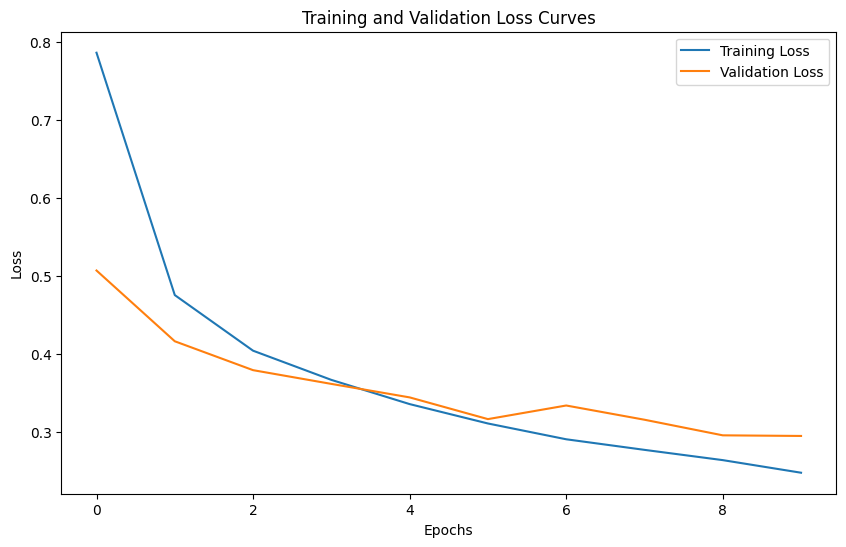

In [4]:
net = models.squeezenet1_1(pretrained=True)

# Print the original classifier structure to understand what changes to make
print(net.classifier)

# Adjust the classifier for CIFAR-10 (10 classes)
net.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1,1), stride=(1,1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
# Train and validate the model
train_losses, val_losses = train_and_validate(net, trainloader, validationloader, criterion, optimizer, epochs=10, model_name='squeezenet_lr00001')

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

## Train CIFAR-10 Model with DP-SGD

Epoch 1, Batch 10, Loss: 3.6704
Train Epoch: 1 	(ε = 0.01, δ = 1.999960000799984e-05)
Epoch 1, Batch 20, Loss: 3.3753
Train Epoch: 1 	(ε = 0.02, δ = 1.999960000799984e-05)
Epoch 1, Batch 30, Loss: 3.3510
Train Epoch: 1 	(ε = 0.02, δ = 1.999960000799984e-05)
Epoch 1, Batch 40, Loss: 3.1144
Train Epoch: 1 	(ε = 0.02, δ = 1.999960000799984e-05)
Epoch 1, Batch 50, Loss: 3.0138
Train Epoch: 1 	(ε = 0.02, δ = 1.999960000799984e-05)
Epoch 1, Batch 60, Loss: 2.9202
Train Epoch: 1 	(ε = 0.02, δ = 1.999960000799984e-05)
Epoch 1, Batch 70, Loss: 2.7929
Train Epoch: 1 	(ε = 0.02, δ = 1.999960000799984e-05)
Epoch 1, Batch 80, Loss: 2.7236
Train Epoch: 1 	(ε = 0.02, δ = 1.999960000799984e-05)
Epoch 1, Batch 90, Loss: 2.5262
Train Epoch: 1 	(ε = 0.02, δ = 1.999960000799984e-05)
Epoch 1, Batch 100, Loss: 2.6703
Train Epoch: 1 	(ε = 0.03, δ = 1.999960000799984e-05)
Epoch 1, Batch 110, Loss: 2.7250
Train Epoch: 1 	(ε = 0.03, δ = 1.999960000799984e-05)
Epoch 1, Batch 120, Loss: 2.5656
Train Epoch: 1 	(ε 

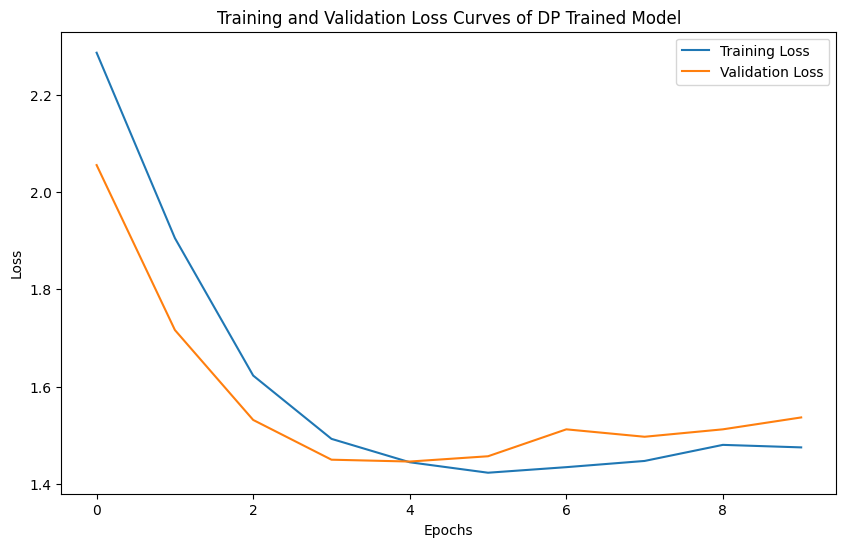

In [93]:
dp_trained_model = models.squeezenet1_1(pretrained=True)
dp_trained_model.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1,1), stride=(1,1))
dp_optimizer = torch.optim.SGD(dp_trained_model.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

privacy_engine = PrivacyEngine()
dp_trained_model, dp_optimizer, dp_trainloader = privacy_engine.make_private(module=dp_trained_model, optimizer=dp_optimizer, data_loader=trainloader,  noise_multiplier=1.3, max_grad_norm=1.0,)

delta = 1.0/(len(trainset)+1)
train_losses, val_losses = train_and_validate(dp_trained_model, dp_trainloader, validationloader, criterion, dp_optimizer, epochs=10, model_name='cifar10_dp', privacy_engine=privacy_engine, delta=delta)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves of DP Trained Model')
plt.legend()
plt.savefig('./privacy/dp_trained_model_lower_lr.png')
plt.show()

# Model Evaluation

In [3]:
def evaluate_model(model, dataloader, extract=False, binary_classifier=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            if binary_classifier:
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.63).long().squeeze()
            else:
                _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if extract:
                labels = torch.squeeze(labels).long()
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

# Pneumonia

In [ ]:
import medmnist
from medmnist import PneumoniaMNIST
from medmnist import INFO

data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])
download = True
size = 224
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# load the pneumonia data
train_dataset_pneumonia = PneumoniaMNIST(split='train', transform=data_transform, download=download, size=size, as_rgb=True)
validation_dataset_pneumonia = PneumoniaMNIST(split='val', transform=data_transform, download=download, size=size, as_rgb=True)
test_dataset_pneumonia = PneumoniaMNIST(split='test', transform=data_transform, download=download, size=size, as_rgb=True)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)
print(info_pneumonia)

# encapsulate data into dataloader form
train_loader_pneumonia = torch.utils.data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
validation_loader_pneumonia = torch.utils.data.DataLoader(dataset=validation_dataset_pneumonia, batch_size=64, shuffle=False)
test_loader_pneumonia = torch.utils.data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

## Train Pneumonia Model with SGD

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)
[0]
Epoch 1, Batch 10, Loss: 0.5747
Epoch 1, Batch 20, Loss: 0.5543
Epoch 1, Batch 30, Loss: 0.4427
Epoch 1, Batch 40, Loss: 0.3872
Epoch 1, Batch 50, Loss: 0.3491
Epoch 1, Batch 60, Loss: 0.3439
Epoch 1, Batch 70, Loss: 0.3383
Epoch 1, Train Loss: 0.4220
Epoch 1, Validation Loss: 0.3107
Epoch 2, Batch 10, Loss: 0.3055
Epoch 2, Batch 20, Loss: 0.2910
Epoch 2, Batch 30, Loss: 0.3021
Epoch 2, Batch 40, Loss: 0.3022
Epoch 2, Batch 50, Loss: 0.3002
Epoch 2, Batch 60, Loss: 0.2991
Epoch 2, Batch 70, Loss: 0.3104
Epoch 2, Train Loss: 0.3014
Epoch 2, Validation Loss: 0.2802
Epoch 3, Batch 10, Loss: 0.2765
Epoch 3, Batch 20, Loss: 0.2952
Epoch 3, Batch 30, Loss: 0.2760
Epoch 3, Batch 40, Loss: 0.3043
Epoch 3, Batch 50, Loss: 0.2754
Epoch 3, Batch 60, Loss: 0.2655
Epoch 3, Batch 70, Loss: 0.2763
Epoch 3, Train Loss:

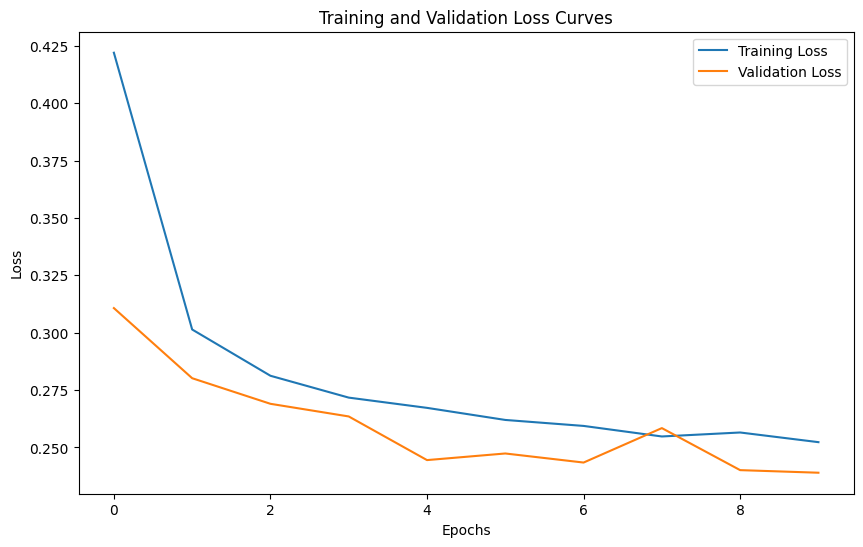

In [32]:
pneumonia_model = models.squeezenet1_1(pretrained=True)

# Print the original classifier structure to understand what changes to make
print(pneumonia_model.classifier)

pneumonia_model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))

criterion = nn.BCEWithLogitsLoss()
pneumonia_optimizer = optim.SGD(pneumonia_model.parameters(), lr=0.0001, momentum=0.9)

print(train_dataset_pneumonia[5][1])
# Train and validate the model
train_losses, val_losses = train_and_validate(pneumonia_model, trainloader=train_loader_pneumonia, validationloader=validation_loader_pneumonia, criterion=criterion, optimizer=pneumonia_optimizer, epochs=10, model_name='pneumonia_model', binary_classifier=True)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

## Pneumonia Model trained with DP-SGD

Epoch 1, Batch 10, Loss: 0.6402


Train Epoch: 1 	(ε = 0.14, δ = 0.00021235931195582927)
Epoch 1, Batch 20, Loss: 0.6726
Train Epoch: 1 	(ε = 0.18, δ = 0.00021235931195582927)
Epoch 1, Batch 30, Loss: 0.6714
Train Epoch: 1 	(ε = 0.22, δ = 0.00021235931195582927)
Epoch 1, Batch 40, Loss: 0.6451
Train Epoch: 1 	(ε = 0.25, δ = 0.00021235931195582927)
Epoch 1, Batch 50, Loss: 0.6455
Train Epoch: 1 	(ε = 0.27, δ = 0.00021235931195582927)
Epoch 1, Batch 60, Loss: 0.6574
Train Epoch: 1 	(ε = 0.30, δ = 0.00021235931195582927)
Epoch 1, Batch 70, Loss: 0.6720
Train Epoch: 1 	(ε = 0.32, δ = 0.00021235931195582927)
Epoch 1, Train Loss: 0.6599
Epoch 1, Validation Loss: 0.5800
Epoch 2, Batch 10, Loss: 0.7020
Train Epoch: 2 	(ε = 0.35, δ = 0.00021235931195582927)
Epoch 2, Batch 20, Loss: 0.7633
Train Epoch: 2 	(ε = 0.37, δ = 0.00021235931195582927)
Epoch 2, Batch 30, Loss: 0.7995
Train Epoch: 2 	(ε = 0.39, δ = 0.00021235931195582927)
Epoch 2, Batch 40, Loss: 0.8120
Train Epoch: 2 	(ε = 0.40, δ = 0.00021235931195582927)
Epoch 2, Batch

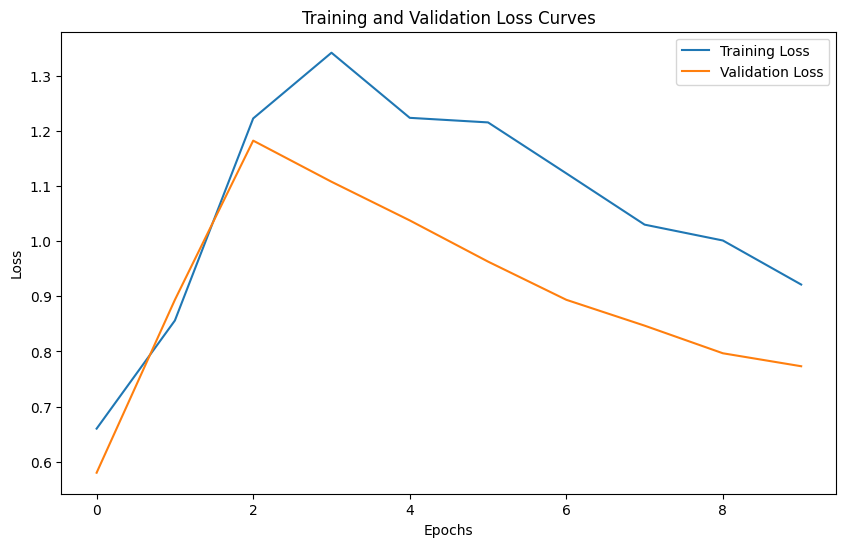

In [89]:
pneumonia_model_dp = models.squeezenet1_1(pretrained=True)
pneumonia_model_dp.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
pneumonia_model_dp_optimizer = torch.optim.SGD(pneumonia_model_dp.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

privacy_engine = PrivacyEngine()
pneumonia_model_dp, pneumonia_model_dp_optimizer, trainloader_pneumonia_dp = privacy_engine.make_private(module=pneumonia_model_dp, optimizer=pneumonia_model_dp_optimizer, data_loader=train_loader_pneumonia,  noise_multiplier=1.3, max_grad_norm=1.0,)
delta = 1.0/(len(train_dataset_pneumonia)+1)

train_losses, val_losses = train_and_validate(pneumonia_model_dp, trainloader=trainloader_pneumonia_dp, validationloader=validation_loader_pneumonia, criterion=criterion, optimizer=pneumonia_model_dp_optimizer, epochs=10, model_name='pneumonia_model_dp', binary_classifier=True, delta=delta, privacy_engine=privacy_engine)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Breast Model

In [ ]:
from medmnist import BreastMNIST
from medmnist import INFO

data_flag_breast = 'breastmnist'
info_breast = INFO[data_flag_breast]
download = True
size = 224
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# load the breast data
train_dataset_breast = BreastMNIST(split='train', transform=data_transform, download=download, size=size, as_rgb=True)
validation_dataset_breast = BreastMNIST(split='val', transform=data_transform, download=download, size=size, as_rgb=True)
test_dataset_breast = BreastMNIST(split='test', transform=data_transform, download=download, size=size, as_rgb=True)

print(info_breast)

# encapsulate data into dataloader form
train_loader_breast = torch.utils.data.DataLoader(dataset=train_dataset_breast, batch_size=64, shuffle=True)
validation_loader_breast = torch.utils.data.DataLoader(dataset=validation_dataset_breast, batch_size=64, shuffle=False)
test_loader_breast = torch.utils.data.DataLoader(dataset=test_dataset_breast, batch_size=64, shuffle=False)

## Breast Model trained with SGD

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)
Epoch 1, Train Loss: 0.5656
Epoch 1, Validation Loss: 0.5953
Epoch 2, Train Loss: 0.5542
Epoch 2, Validation Loss: 0.5677
Epoch 3, Train Loss: 0.5437
Epoch 3, Validation Loss: 0.5579
Epoch 4, Train Loss: 0.5345
Epoch 4, Validation Loss: 0.5501
Epoch 5, Train Loss: 0.5273
Epoch 5, Validation Loss: 0.5487
Epoch 6, Train Loss: 0.5238
Epoch 6, Validation Loss: 0.5425
Epoch 7, Train Loss: 0.5146
Epoch 7, Validation Loss: 0.5366
Epoch 8, Train Loss: 0.5156
Epoch 8, Validation Loss: 0.5354
Epoch 9, Train Loss: 0.5151
Epoch 9, Validation Loss: 0.5289
Epoch 10, Train Loss: 0.5075
Epoch 10, Validation Loss: 0.5273


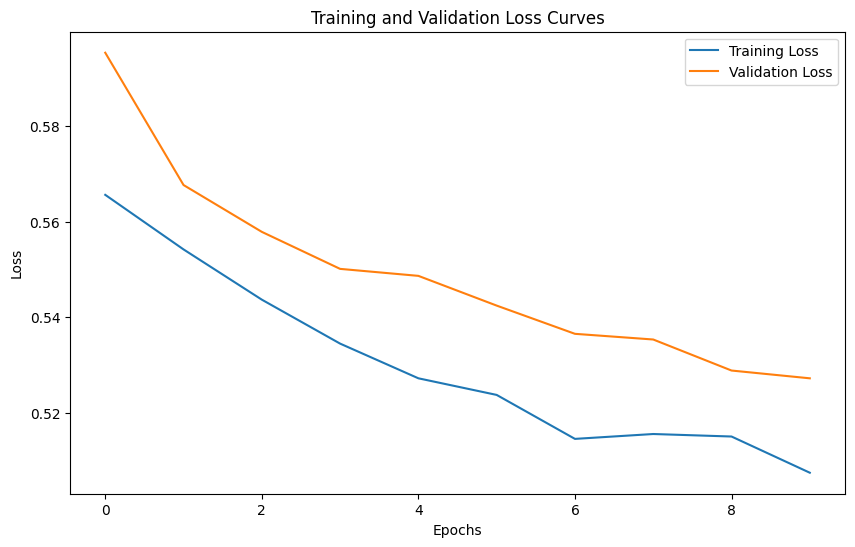

In [34]:
breast_model = models.squeezenet1_1(pretrained=True)

# Print the original classifier structure to understand what changes to make
print(breast_model.classifier)

breast_model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))

criterion = nn.BCEWithLogitsLoss()
breast_optimizer = optim.SGD(breast_model.parameters(), lr=0.0001, momentum=0.9)

# Train and validate the model
train_losses, val_losses = train_and_validate(breast_model, trainloader=train_loader_breast, validationloader=validation_loader_breast, criterion=criterion, optimizer=breast_optimizer, epochs=10, model_name='breast_model', binary_classifier=True)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Breast Model trained with DP-SGD

Train Epoch: 1 	(ε = 0.89, δ = 0.0018281535648994515)
Epoch 1, Train Loss: 0.6133
Epoch 1, Validation Loss: 0.6243
Train Epoch: 2 	(ε = 1.25, δ = 0.0018281535648994515)
Epoch 2, Train Loss: 0.5951
Epoch 2, Validation Loss: 0.6196
Train Epoch: 3 	(ε = 1.54, δ = 0.0018281535648994515)
Epoch 3, Train Loss: 0.5873
Epoch 3, Validation Loss: 0.6138
Train Epoch: 4 	(ε = 1.79, δ = 0.0018281535648994515)
Epoch 4, Train Loss: 0.5627
Epoch 4, Validation Loss: 0.6076
Train Epoch: 5 	(ε = 2.02, δ = 0.0018281535648994515)
Epoch 5, Train Loss: 0.5722
Epoch 5, Validation Loss: 0.6019
Train Epoch: 6 	(ε = 2.23, δ = 0.0018281535648994515)
Epoch 6, Train Loss: 0.5433
Epoch 6, Validation Loss: 0.5978
Train Epoch: 7 	(ε = 2.43, δ = 0.0018281535648994515)
Epoch 7, Train Loss: 0.6332
Epoch 7, Validation Loss: 0.5966
Train Epoch: 8 	(ε = 2.62, δ = 0.0018281535648994515)
Epoch 8, Train Loss: 0.5602
Epoch 8, Validation Loss: 0.5986
Train Epoch: 9 	(ε = 2.80, δ = 0.0018281535648994515)
Epoch 9, Train Loss: 0.642

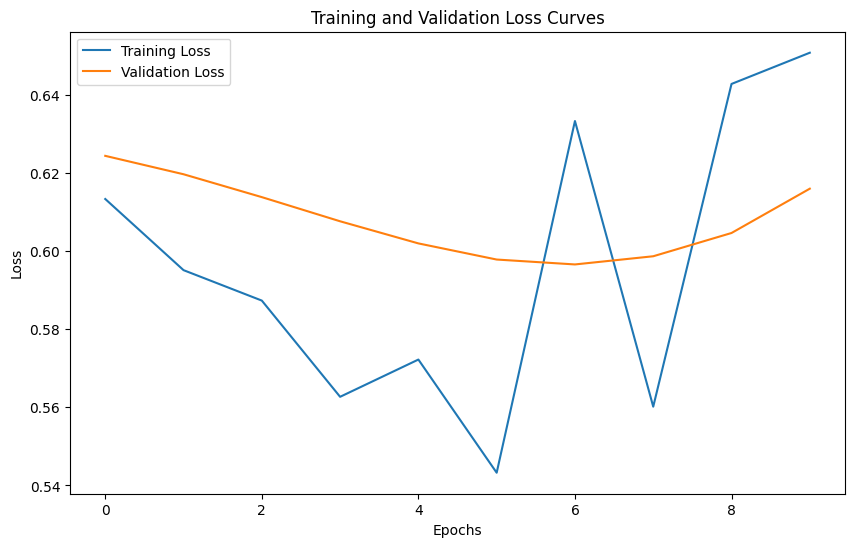

In [56]:
breast_model_dp = models.squeezenet1_1(pretrained=True)
breast_model_dp.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
breast_model_dp_optimizer = torch.optim.SGD(breast_model_dp.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

privacy_engine = PrivacyEngine()
breast_model_dp, breast_model_dp_optimizer, trainloader_breast_dp = privacy_engine.make_private(module=breast_model_dp, optimizer=breast_model_dp_optimizer, data_loader=train_loader_breast,  noise_multiplier=1.3, max_grad_norm=1.0,)
delta = 1.0/(len(train_dataset_breast)+1)

train_losses, val_losses = train_and_validate(breast_model_dp, trainloader=trainloader_breast_dp, validationloader=validation_loader_breast, criterion=criterion, optimizer=breast_model_dp_optimizer, epochs=10, model_name='breast_model_dp', binary_classifier=True, delta=delta, privacy_engine=privacy_engine)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# DermaMNIST

In [ ]:
from medmnist import DermaMNIST
from medmnist import INFO

data_flag_derma = 'dermamnist'
info_derma = INFO[data_flag_derma]
download = True
size = 224
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# load the derma data
train_dataset_derma = DermaMNIST(split='train', transform=data_transform, download=download, size=size, as_rgb=True)
validation_dataset_derma = DermaMNIST(split='val', transform=data_transform, download=download, size=size, as_rgb=True)
test_dataset_derma = DermaMNIST(split='test', transform=data_transform, download=download, size=size, as_rgb=True)

print(info_derma)

# encapsulate data into dataloader form
train_loader_derma = torch.utils.data.DataLoader(dataset=train_dataset_derma, batch_size=64, shuffle=True)
validation_loader_derma = torch.utils.data.DataLoader(dataset=validation_dataset_derma, batch_size=64, shuffle=False)
test_loader_derma = torch.utils.data.DataLoader(dataset=test_dataset_derma, batch_size=64, shuffle=False)

## Derma Model trained with SGD

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)
Epoch 1, Batch 10, Loss: 1.8776
Epoch 1, Batch 20, Loss: 1.2413
Epoch 1, Batch 30, Loss: 1.1233
Epoch 1, Batch 40, Loss: 1.0351
Epoch 1, Batch 50, Loss: 0.9706
Epoch 1, Batch 60, Loss: 1.0477
Epoch 1, Batch 70, Loss: 1.0078
Epoch 1, Batch 80, Loss: 0.9764
Epoch 1, Batch 90, Loss: 0.9402
Epoch 1, Batch 100, Loss: 0.9060
Epoch 1, Batch 110, Loss: 0.9451
Epoch 1, Train Loss: 1.0974
Epoch 1, Validation Loss: 0.9186
Epoch 2, Batch 10, Loss: 0.9071
Epoch 2, Batch 20, Loss: 0.9291
Epoch 2, Batch 30, Loss: 0.9150
Epoch 2, Batch 40, Loss: 0.8898
Epoch 2, Batch 50, Loss: 0.7736
Epoch 2, Batch 60, Loss: 0.9296
Epoch 2, Batch 70, Loss: 0.9953
Epoch 2, Batch 80, Loss: 0.9233
Epoch 2, Batch 90, Loss: 0.8585
Epoch 2, Batch 100, Loss: 0.9248
Epoch 2, Batch 110, Loss: 0.8908
Epoch 2, Train Loss: 0.9034
Epoch 2, Validation L

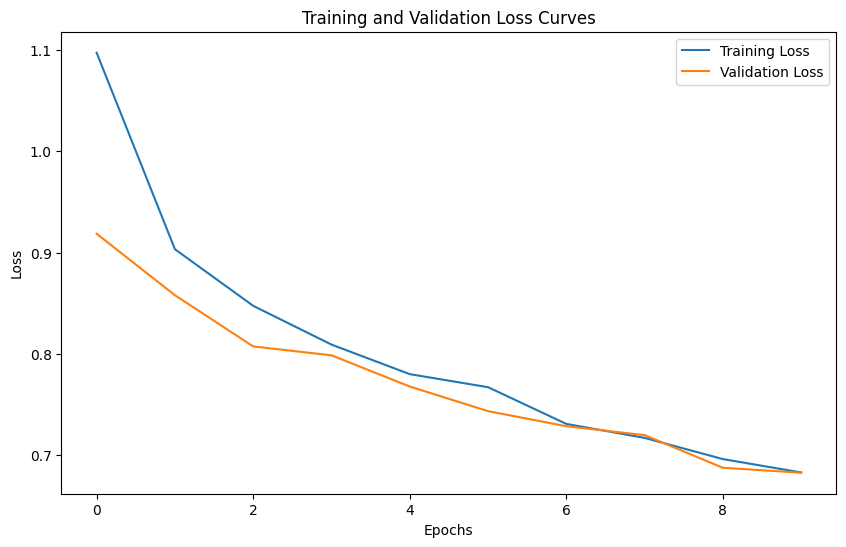

In [5]:
derma_model = models.squeezenet1_1(pretrained=True)

# Print the original classifier structure to understand what changes to make
print(derma_model.classifier)

derma_model.classifier[1] = nn.Conv2d(512, 7, kernel_size=(1,1), stride=(1,1))

criterion = nn.CrossEntropyLoss()
derma_optimizer = optim.SGD(derma_model.parameters(), lr=0.0001, momentum=0.9)

# Train and validate the model
train_losses, val_losses = train_and_validate(derma_model, trainloader=train_loader_derma, validationloader=validation_loader_derma, criterion=criterion, optimizer=derma_optimizer, epochs=10, model_name='derma_model', binary_classifier=False, extract=True)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Derma Model trained with DP-SGD

Epoch 1, Batch 10, Loss: 1.9921
Train Epoch: 1 	(ε = 0.10, δ = 0.00014269406392694063)
Epoch 1, Batch 20, Loss: 1.8585
Train Epoch: 1 	(ε = 0.13, δ = 0.00014269406392694063)
Epoch 1, Batch 30, Loss: 1.7429
Train Epoch: 1 	(ε = 0.15, δ = 0.00014269406392694063)
Epoch 1, Batch 40, Loss: 1.6993
Train Epoch: 1 	(ε = 0.17, δ = 0.00014269406392694063)
Epoch 1, Batch 50, Loss: 1.5403
Train Epoch: 1 	(ε = 0.19, δ = 0.00014269406392694063)
Epoch 1, Batch 60, Loss: 1.4952
Train Epoch: 1 	(ε = 0.20, δ = 0.00014269406392694063)
Epoch 1, Batch 70, Loss: 1.5593
Train Epoch: 1 	(ε = 0.22, δ = 0.00014269406392694063)
Epoch 1, Batch 80, Loss: 1.4603
Train Epoch: 1 	(ε = 0.23, δ = 0.00014269406392694063)
Epoch 1, Batch 90, Loss: 1.4051
Train Epoch: 1 	(ε = 0.25, δ = 0.00014269406392694063)
Epoch 1, Batch 100, Loss: 1.3100
Train Epoch: 1 	(ε = 0.26, δ = 0.00014269406392694063)
Epoch 1, Batch 110, Loss: 1.3113
Train Epoch: 1 	(ε = 0.27, δ = 0.00014269406392694063)
Epoch 1, Train Loss: 1.5795
Epoch 1, Vali

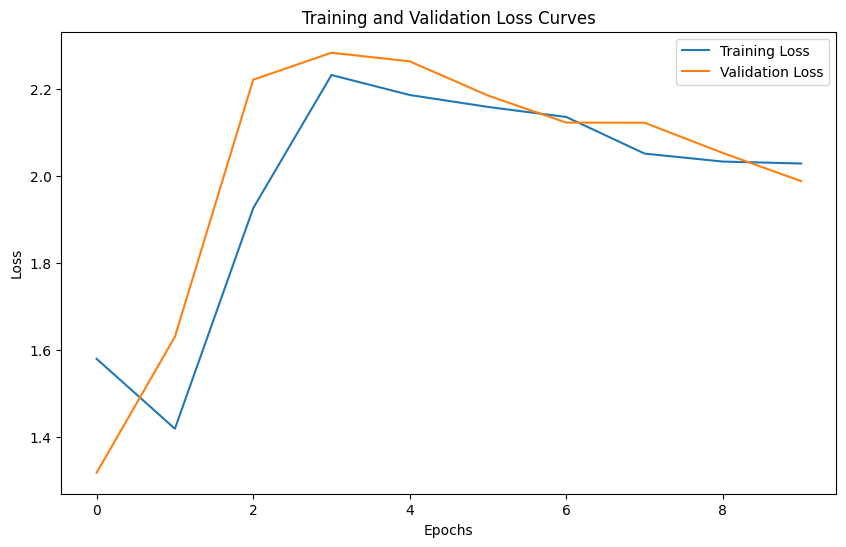

In [90]:
derma_model_dp = models.squeezenet1_1(pretrained=True)
derma_model_dp.classifier[1] = nn.Conv2d(512, 7, kernel_size=(1,1), stride=(1,1))
derma_model_dp_optimizer = torch.optim.SGD(derma_model_dp.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

privacy_engine = PrivacyEngine()
derma_model_dp, derma_model_dp_optimizer, trainloader_derma_dp = privacy_engine.make_private(module=derma_model_dp, optimizer=derma_model_dp_optimizer, data_loader=train_loader_derma,  noise_multiplier=1.3, max_grad_norm=1.0,)
delta = 1.0/(len(train_dataset_derma)+1)

train_losses, val_losses = train_and_validate(derma_model_dp, trainloader=trainloader_derma_dp, validationloader=validation_loader_derma, criterion=criterion, optimizer=derma_model_dp_optimizer, epochs=10, model_name='derma_model_dp', binary_classifier=False, extract=True, delta=delta, privacy_engine=privacy_engine)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Evaluation

## Evaluation on Cifar10

In [12]:
squeezenet1_1 = models.squeezenet1_1(pretrained=True)
squeezenet1_1.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1,1), stride=(1,1))
squeezenet1_1.load_state_dict(torch.load('./privacy/models/squeezenet_lr00001_epoch10.pth'))
dp_trained_model = models.squeezenet1_1(pretrained=True)
dp_trained_model.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1,1), stride=(1,1))
privacy_engine = PrivacyEngine()
dp_optimizer = torch.optim.SGD(dp_trained_model.parameters(), lr=0.0001, momentum=0.9)
dp_trained_model, _,_ = privacy_engine.make_private(module=dp_trained_model, optimizer=dp_optimizer, data_loader=trainloader,  noise_multiplier=1.3, max_grad_norm=1.0,)
dp_trained_model.load_state_dict(torch.load('./privacy/models/cifar10_dp_epoch10.pth'))

evaluate_model(squeezenet1_1, testloader)
evaluate_model(dp_trained_model, testloader)

Accuracy of the model on the test images: 89.38%
Accuracy of the model on the test images: 61.78%


## Evaluation Pneumonia

In [14]:
pneumonia_model = models.squeezenet1_1(pretrained=True)
pneumonia_model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
pneumonia_model.load_state_dict(torch.load('./privacy/models/pneumonia_model_epoch10.pth'))

pneumonia_model_dp = models.squeezenet1_1(pretrained=True)
pneumonia_model_dp.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
privacy_engine = PrivacyEngine()
pneumonia_model_dp_optimizer = torch.optim.SGD(pneumonia_model_dp.parameters(), lr=0.0001, momentum=0.9)
pneumonia_model_dp, _,_ = privacy_engine.make_private(module=pneumonia_model_dp, optimizer=pneumonia_model_dp_optimizer, data_loader=train_loader_pneumonia,  noise_multiplier=1.3, max_grad_norm=1.0,)
pneumonia_model_dp.load_state_dict(torch.load('./privacy/models/pneumonia_model_dp_epoch10.pth'))

evaluate_model(pneumonia_model, test_loader_pneumonia, binary_classifier=True, extract=True)
evaluate_model(pneumonia_model_dp, test_loader_pneumonia, binary_classifier=True, extract=True)

Accuracy of the model on the test images: 91.34615384615384%
Accuracy of the model on the test images: 62.5%


## Evaluation Breast Model

In [16]:
breast_model = models.squeezenet1_1(pretrained=True)
breast_model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
breast_model.load_state_dict(torch.load('./privacy/models/breast_model_epoch10.pth'))

breast_model_dp = models.squeezenet1_1(pretrained=True)
breast_model_dp.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
privacy_engine = PrivacyEngine()
breast_model_dp_optimizer = torch.optim.SGD(breast_model_dp.parameters(), lr=0.0001, momentum=0.9)
breast_model_dp, _,_ = privacy_engine.make_private(module=breast_model_dp, optimizer=breast_model_dp_optimizer, data_loader=train_loader_breast,  noise_multiplier=1.3, max_grad_norm=1.0,)
breast_model_dp.load_state_dict(torch.load('./privacy/models/breast_model_dp_epoch10.pth'))

evaluate_model(breast_model, test_loader_breast, binary_classifier=True, extract=True)
evaluate_model(breast_model_dp, test_loader_breast, binary_classifier=True, extract=True)

Accuracy of the model on the test images: 79.48717948717949%
Accuracy of the model on the test images: 73.07692307692308%


## Evaluation Derma Models

In [17]:
derma_model = models.squeezenet1_1(pretrained=True)
derma_model.classifier[1] = nn.Conv2d(512, 7, kernel_size=(1,1), stride=(1,1))
derma_model.load_state_dict(torch.load('./privacy/models/derma_model_epoch10.pth'))

derma_model_dp = models.squeezenet1_1(pretrained=True)
derma_model_dp.classifier[1] = nn.Conv2d(512, 7, kernel_size=(1,1), stride=(1,1))
derma_model_dp_optimizer = torch.optim.SGD(derma_model_dp.parameters(), lr=0.0001, momentum=0.9)
privacy_engine = PrivacyEngine()
derma_model_dp, _,_ = privacy_engine.make_private(module=derma_model_dp, optimizer=derma_model_dp_optimizer, data_loader=train_loader_derma,  noise_multiplier=1.3, max_grad_norm=1.0,)
derma_model_dp.load_state_dict(torch.load('./privacy/models/derma_model_dp_epoch10.pth'))

evaluate_model(derma_model, test_loader_derma, extract=True)
evaluate_model(derma_model_dp, test_loader_derma, extract=True)

Accuracy of the model on the test images: 75.66084788029926%
Accuracy of the model on the test images: 66.98254364089776%


In [ ]:
cifar10_normal_time = 320
cifar10_dp_time = 570
pneumonia_normal_time = 74.0
pneumonia_dp_time = 65
breast_normal_time = 4
breast_dp_time = 4.5
derma_normal_time = 48
derma_dp_time = 70

# Hyperparameter Study

In [ ]:
batch_sizes = [16,32, 64]
epoch = 10
max_grad_norms = [0.5, 1.0, 1.5]
noise_multipliers = [0.5, 1.0, 1.5]
delta = 1.0/(len(train_dataset_breast)+1)
criterion = nn.BCEWithLogitsLoss()

for b in batch_sizes:
    for max_grad_norm in max_grad_norms:
        for noise_multiplier in noise_multipliers:
            try:
                breast_model_dp = models.squeezenet1_1(pretrained=True)
                breast_model_dp.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
                train_loader_breast = torch.utils.data.DataLoader(dataset=train_dataset_breast, batch_size=b, shuffle=True)
                breast_model_dp_optimizer = torch.optim.SGD(breast_model_dp.parameters(), lr=0.0001, momentum=0.9)
                privacy_engine = PrivacyEngine()
                breast_model_dp, breast_model_dp_optimizer, trainloader_breast_dp = privacy_engine.make_private(module=breast_model_dp, optimizer=breast_model_dp_optimizer, data_loader=train_loader_breast,  noise_multiplier=noise_multiplier, max_grad_norm=max_grad_norm,)
                train_losses, val_losses, epsilons = train_and_validate(breast_model_dp, trainloader=trainloader_breast_dp, validationloader=validation_loader_breast, criterion=criterion, optimizer=breast_model_dp_optimizer, epochs=epoch, binary_classifier=True, delta=delta, privacy_engine=privacy_engine)
                
                plt.figure(figsize=(10, 6))
                plt.plot(epsilons, label='Epsilon')
                plt.xlabel('Epochs')
                plt.ylabel('Privacy Loss')
                plt.title('Epsilon with batch size {}, epoch {}, max_grad_norm {}, noise_multiplier {}'.format(b, epoch, max_grad_norm, noise_multiplier))
                plt.legend()
                plt.show()

                print('With batch size {}, epoch {}, noise_multiplier {}, max_grad_norm {}'.format(b, epoch, noise_multiplier, max_grad_norm))
                evaluate_model(breast_model_dp, test_loader_breast, binary_classifier=True, extract=True)

            except Exception as e:
                print('With batch size {}, epoch {}, max_grad_norm {}, noise_multiplier {} occured an error'.format(b, epoch, max_grad_norm, noise_multiplier))
                print(e)


In [ ]:
from torch.utils.data import random_split

split_length = int(len(train_dataset_derma)*0.6)
subset, _ = random_split(train_dataset_derma, [split_length, len(train_dataset_derma)-split_length])
print(len(subset))

batch_sizes = [32, 64]
epoch = 10
max_grad_norms = [1.0, 1.5]
noise_multipliers = [1.0, 1.5]
delta = 1.0/(len(subset)+1)
criterion = nn.CrossEntropyLoss()

for b in batch_sizes:
    for max_grad_norm in max_grad_norms:
        for noise_multiplier in noise_multipliers:
            try:
                print('With batch size {}, epoch {}, noise_multiplier {}, max_grad_norm {}'.format(b, epoch, noise_multiplier, max_grad_norm))
                derma_model_dp = models.squeezenet1_1(pretrained=True)
                derma_model_dp.classifier[1] = nn.Conv2d(512, 7, kernel_size=(1,1), stride=(1,1))
                train_loader_derma = torch.utils.data.DataLoader(dataset=subset, batch_size=b, shuffle=True)
                derma_model_dp_optimizer = torch.optim.SGD(derma_model_dp.parameters(), lr=0.0001, momentum=0.9)
                privacy_engine = PrivacyEngine()
                derma_model_dp, derma_model_dp_optimizer, trainloader_derma_dp = privacy_engine.make_private(module=derma_model_dp, optimizer=derma_model_dp_optimizer, data_loader=train_loader_derma,  noise_multiplier=noise_multiplier, max_grad_norm=max_grad_norm,)
                train_losses, val_losses, epsilons = train_and_validate(derma_model_dp, trainloader=trainloader_derma_dp, validationloader=validation_loader_derma, criterion=criterion, optimizer=derma_model_dp_optimizer, epochs=epoch,extract=True, delta=delta, privacy_engine=privacy_engine)
        
                print(f'epsilon = {epsilons[-1]}')
                evaluate_model(derma_model_dp, test_loader_derma, extract=True)

            except Exception as e:
                print('With batch size {}, epoch {}, noise_multiplier {}, max_grad_norm {} occured an error'.format(b, epoch, noise_multiplier, max_grad_norm))
                print(e)
            print("___________________________________________________________________________________________")
            

# Summary

## Comparison between different models

| Model         | Accuracy (%) | 𝜖 (Privacy Loss) | Time to train (min) |
|---------------|--------------|-------------------|---------------------|
| Pneumonia     | 91.35        | Inf               | 45                  |
| Pneumonia_dp  | 62.5         | 1.05              | 65                  |
| Breast        | 79.49        | Inf               | 4                   |
| Breast_dp     | 73.98        | 2.97              | 4.5                 |
| Derma         | 75.67        | Inf               | 48                  |
| Derma_dp      | 66.99        | 0.87              | 70                  |

The application of DP resulted in varying degrees of accuracy reduction and training time increases, with the magnitude of these effects influenced by the size of the dataset and the complexity of the task.
PneumoniaMNIST showed a substantial drop in accuracy with DP, alongside an increase in training time, reflecting the larger dataset's challenge in maintaining accuracy while ensuring privacy (ε=1.05).
BreastMNIST, the smallest dataset, had a relatively minor accuracy decrease under DP and a slight training time increase, yet it exhibited the highest ε value (2.97), suggesting that smaller datasets might require more significant privacy compromises.
DermaMNIST, with a moderate dataset size, demonstrated a balanced outcome in terms of accuracy decrease and ε value (0.87), indicating a moderate impact of DP.
These results underscore that the effectiveness and efficiency of DP in medical imaging tasks are closely tied to dataset size, with smaller datasets potentially necessitating larger ε values for comparable privacy guarantees. This suggests a nuanced balance must be struck between dataset characteristics, privacy needs, and model performance, highlighting the need for tailored DP strategies in medical applications.

## Hyperparameter Study

We conducted a Hyperparameter study on the different previously used MedMNIST datasets.

### BreastMNIST:
We varied the following Hyperparameters in the range and performed grid search:
- Epochs: [5, 10]
- Batch_Size: [16,32,64]
- Noise_multiplier: [0.5, 1.0, 1.5]
- Max_grad_norms. [0.5, 1.0, 1.5]
 
We conducted a Hyperparameter study on the DermaModel trained with DP-SGD:

| Epoch | Batch size | Noise_multiplier | max_grad_norms | Accuracy | 𝜖    |
|-------|------------|------------------|----------------|----------|------|
| 5     | 16         | 0.5              | 0.5            | 73.08    | 9.06 |
| 5     | 16         | 1.0              | 0.5            | 72.0     | 1.42 |
| 5     | 16         | 1.5              | 0.5            | 71.8     | 0.68 |
| 5     | 16         | 0.5              | 1.0            | 73.08    | 9.06 |
| 10    | 16         | 0.5              | 0.5            | 73.08    | 12.95|
| 10    | 16         | 1.0              | 0.5            | 73.08    | 2.07 |
| 10    | 16         | 1.5              | 0.5            | 73.08    | 1.01 |
| 10    | 16         | 0.5              | 1.0            | 73.08    | 12.95|
| 10    | 16         | 1.0              | 1.0            | 73.08    | 2.07 |
| 10    | 16         | 1.5              | 1.0            | 73.08    | 1.07 |
| 10    | 16         | 0.5              | 1.5            | 73.08    | 12.95|
| 10    | 16         | 1.0              | 1.5            | 73.08    | 2.07 |
| 10    | 16         | 1.5              | 1.5            | 73.08    | 1.01 |
| 10    | 32         | 0.5              | 0.5            | 73.72    | 17.01|
| 10    | 32         | 1.0              | 0.5            | 73.08    | 3.13 |
| 10    | 32         | 1.5              | 0.5            | 73.08    | 1.53 |
| 10    | 32         | 0.5              | 1.0            | 73.08    | 17.01|
| 10    | 32         | 1.0              | 1.0            | 73.08    | 3.13 |
| 10    | 32         | 1.5              | 1.0            | 73.08    | 1.53 |
| 10    | 32         | 0.5              | 1.5            | 73.08    | 17.01|
| 10    | 32         | 1.0              | 1.5            | 73.08    | 3.13 |
| 10    | 32         | 1.5              | 1.5            | 73.08    | 1.53 |
| 10    | 64         | 0.5              | 0.5            | -        | -    |
| 10    | 64         | 1.0              | 0.5            | -        | -    |
| 10    | 64         | 1.5              | 0.5            | 66.02    | 2.35 |
| 10    | 64         | 0.5              | 1.0            | -        | -    |
| 10    | 64         | 1.0              | 1.0            | -        | -    |
| 10    | 64         | 1.5              | 1.0            | 73.08    | 2.35 |
| 10    | 64         | 0.5              | 1.5            | -        | -    |
| 10    | 64         | 1.0              | 1.5            | -        | -    |
| 10    | 64         | 1.5              | 1.5            | 73.08    | 2.35 |

Our hyperparameter exploration within the BreastMNIST dataset revealed key insights into the differential privacy (DP) parameters’ impact on model performance and privacy. Specifically,
variations in the noise multiplier and maximum gradient norm demonstrated their crucial roles in balancing privacy guarantees against model accuracy.
An increase in the noise multiplier directly enhances privacy by adding uncertainty to the data, evident in reduced ε values, but without significantly compromising model accuracy across various settings. Similarly, adjusting the maximum gradient norm, which limits the influence of individual data points on model updates, proved essential for strengthening privacy. These findings highlight a critical trade-off: while tighter privacy controls (lower ε values) can be achieved through higher noise levels and stricter gradient norms, the model's ability to learn from the data is concurrently constrained.
Despite the dataset's binary nature and potential imbalance, we observed a consistent accuracy plateau at 73.08%, suggesting that the dataset characteristics significantly influence the efficacy of DP adjustments. Configuration such as epoch = 10, batch_size = 64, noise_multiplier = 1.0 max_grad_norms = 1.0 resulted in an error raised by Opacus, stating ‘Discrete mean differs significantly from continuous mean.’

### DermaMNIST

| Batch Size | Noise_multiplier | Max_grad_norms | Accuracy | 𝜖   |
|------------|------------------|----------------|----------|-----|
| 32         | 1.0              | 1.0            | 66.83    | 1.18|
| 32         | 1.5              | 1.0            | 67.08    | 0.6 |
| 32         | 1.0              | 1.5            | 66.93    | 1.18|
| 32         | 1.5              | 1.5            | 66.68    | 0.6 |
| 64         | 1.0              | 1.0            | 66.88    | 1.9 |
| 64         | 1.5              | 1.0            | 66.88    | 0.9 |
| 64         | 1.0              | 1.5            | 66.90    | 1.8 |
| 64         | 1.5              | 1.5            | 66.88    | 0.90|

The analysis of the DermaMNIST dataset under differential privacy (DP) settings shows that higher noise multipliers can enhance privacy (lower ε) without significantly compromising accuracy. Across different batch sizes, this effect remains consistent, indicating a robust balance between privacy and model performance. Notably, adjustments in DP parameters, such as the noise multiplier and maximum gradient norm, offer a viable path to maintaining model utility while ensuring strong privacy protections in medical image analysis.
Comparing the differential privacy (DP) experiments on the DermaMNIST dataset to a non-DP baseline (75% accuracy), the introduction of DP parameters—noise multipliers and maximum gradient norms—demonstrates a modest reduction in accuracy for enhanced privacy. Despite this, DP configurations, particularly with higher noise multipliers, effectively lower ε values, indicating stronger privacy, with minimal impact on accuracy. This trade-off highlights the feasibility of applying DP to achieve significant privacy protections with a relatively small compromise in model performance compared to the non-DP scenario.